In [1]:
from pathlib import Path
import os
import pandas as pd
from psifr import fr
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from cymr import network
from cymr import cmr

from dcmr import task
from dcmr import framework

cfr_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS']).parent

data_file = cfr_dir / 'cfr_data.csv'
patterns_file = cfr_dir / 'cfr_patterns.hdf5'

In [2]:
data = task.read_free_recall(data_file)
patterns = cmr.load_patterns(patterns_file)

In [3]:
input_crp = data.groupby('n_block').apply(
    fr.input_crp, input_key='block', count_unique=False, include_groups=False
)

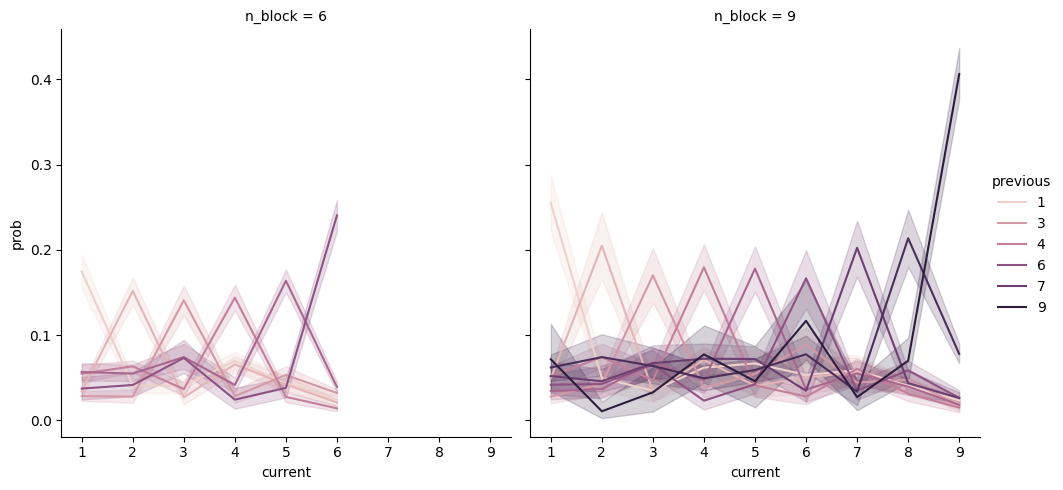

In [4]:
sns.relplot(input_crp, x='current', hue='previous', y='prob', kind='line', col='n_block');

In [5]:
models = [
    'v5/cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1', 
    'v7/manual/cmrsl_focused', 
    'v7/manual/cmrsl_focused_disrupt_w0extend_identifiable4', 
    'v7/manual/cmrsl_focused_disrupt_w0extend_identifiable4_block3',
]
model_names = ['focused', 'list', 'list + disrupt', 'list + block + disrupt']
full = framework.read_model_sims(data_file, fit_dir, models, model_names, block=True)

In [6]:
input_crp = full.groupby(['source', 'n_block']).apply(
    fr.input_crp, input_key='block', count_unique=False, include_groups=False
)

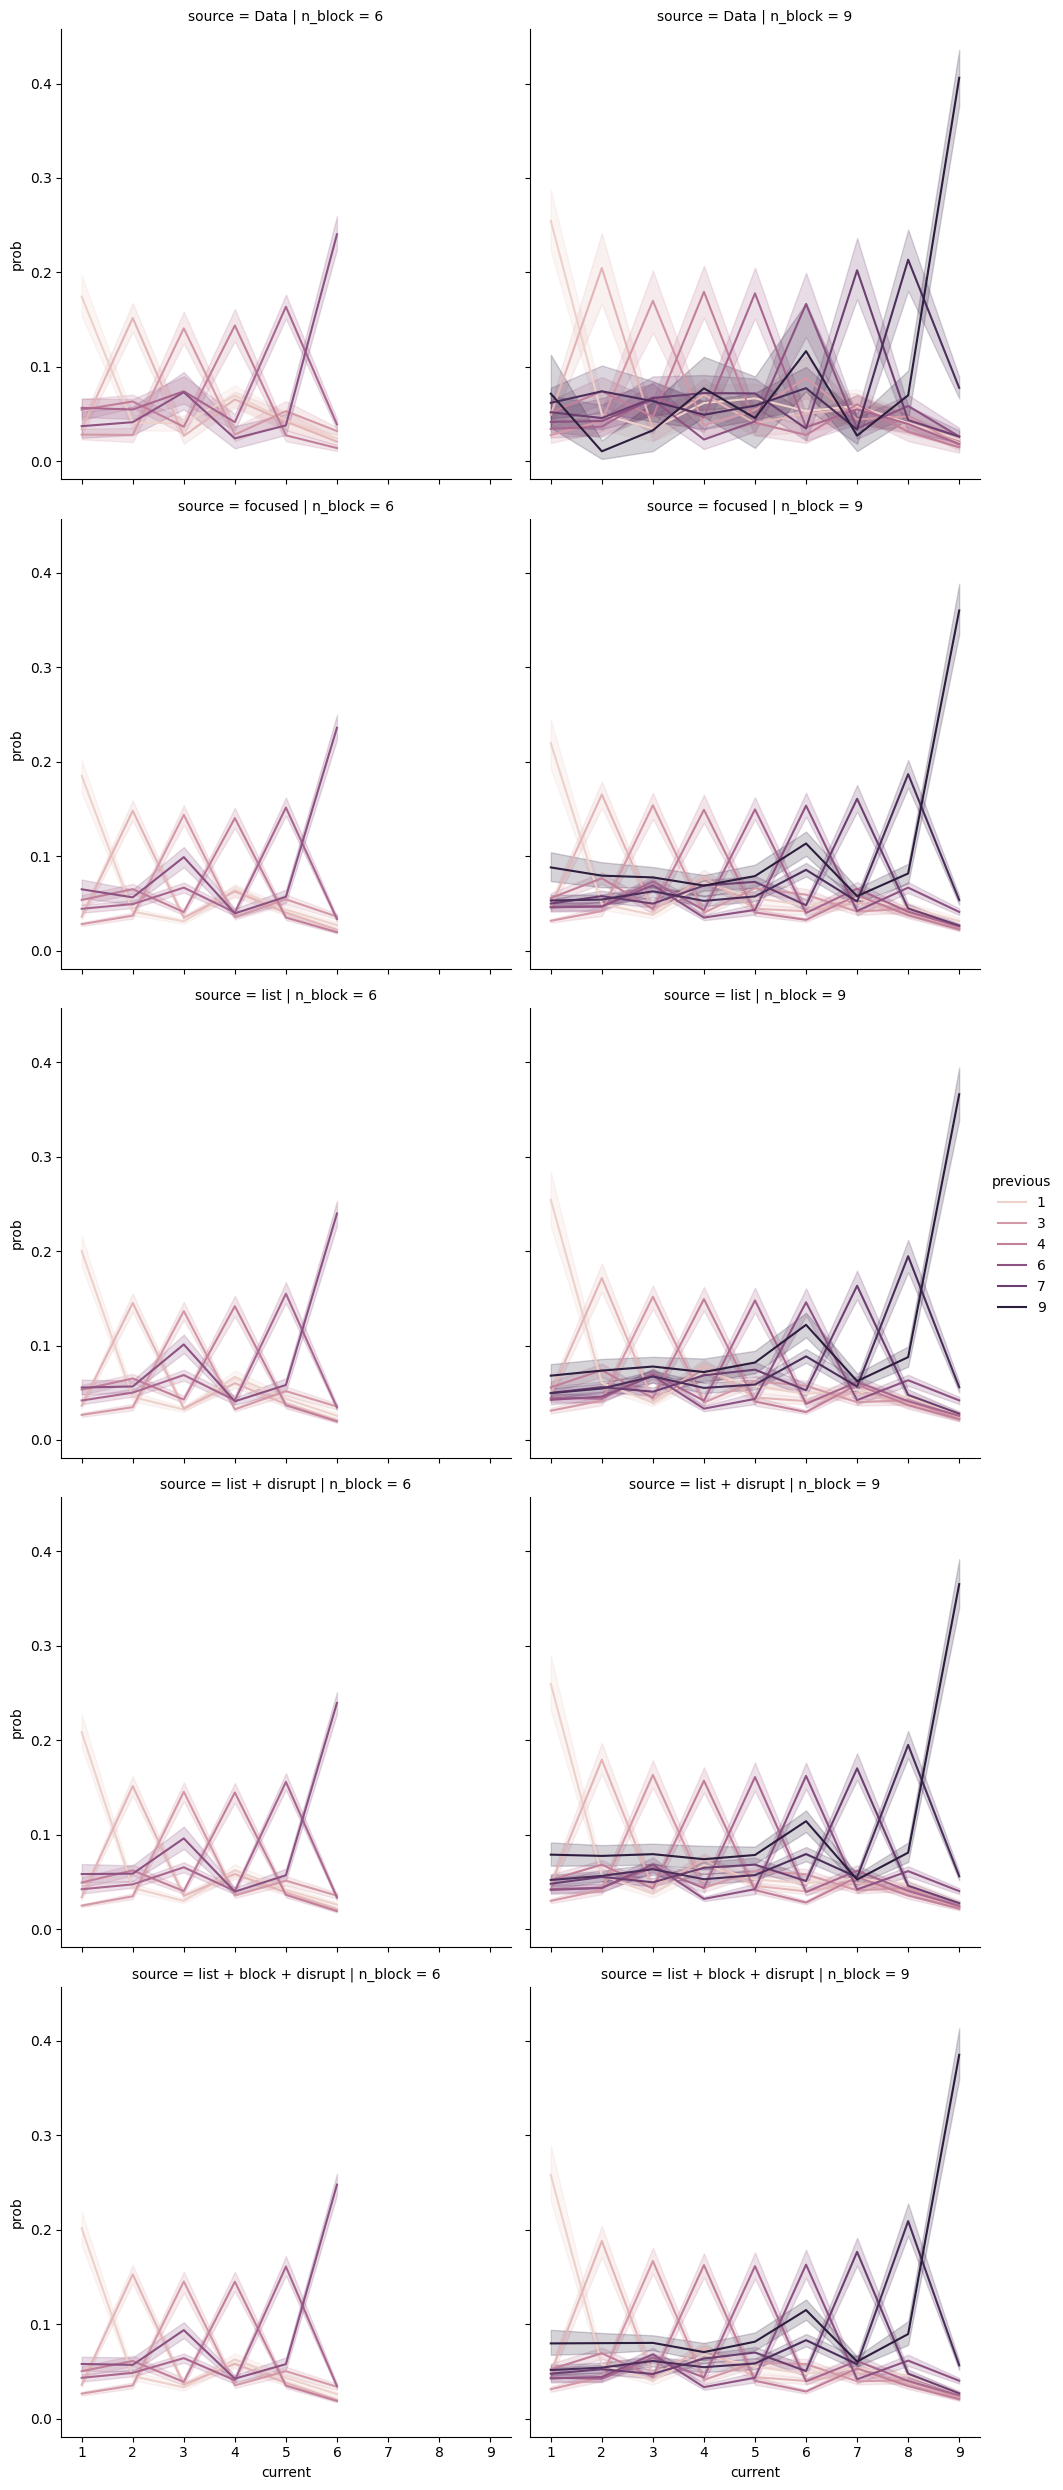

In [7]:
sns.relplot(
    input_crp, 
    x='current', 
    hue='previous', 
    y='prob', 
    kind='line', 
    col='n_block', 
    row='source', 
    row_order=['Data'] + model_names,
);

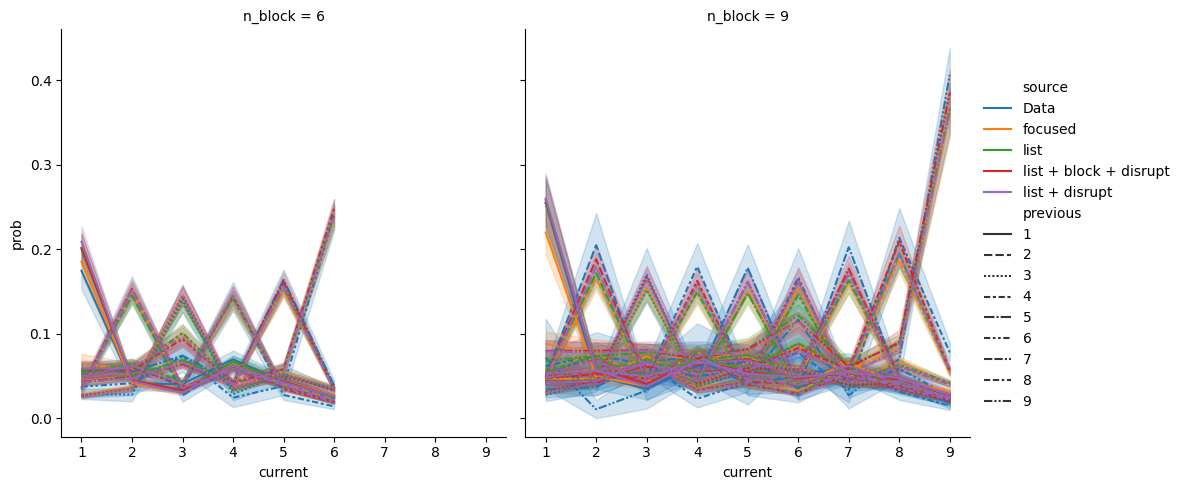

In [8]:
sns.relplot(
    input_crp, 
    x='current', 
    style='previous', 
    y='prob', 
    kind='line', 
    col='n_block', 
    hue='source',
);

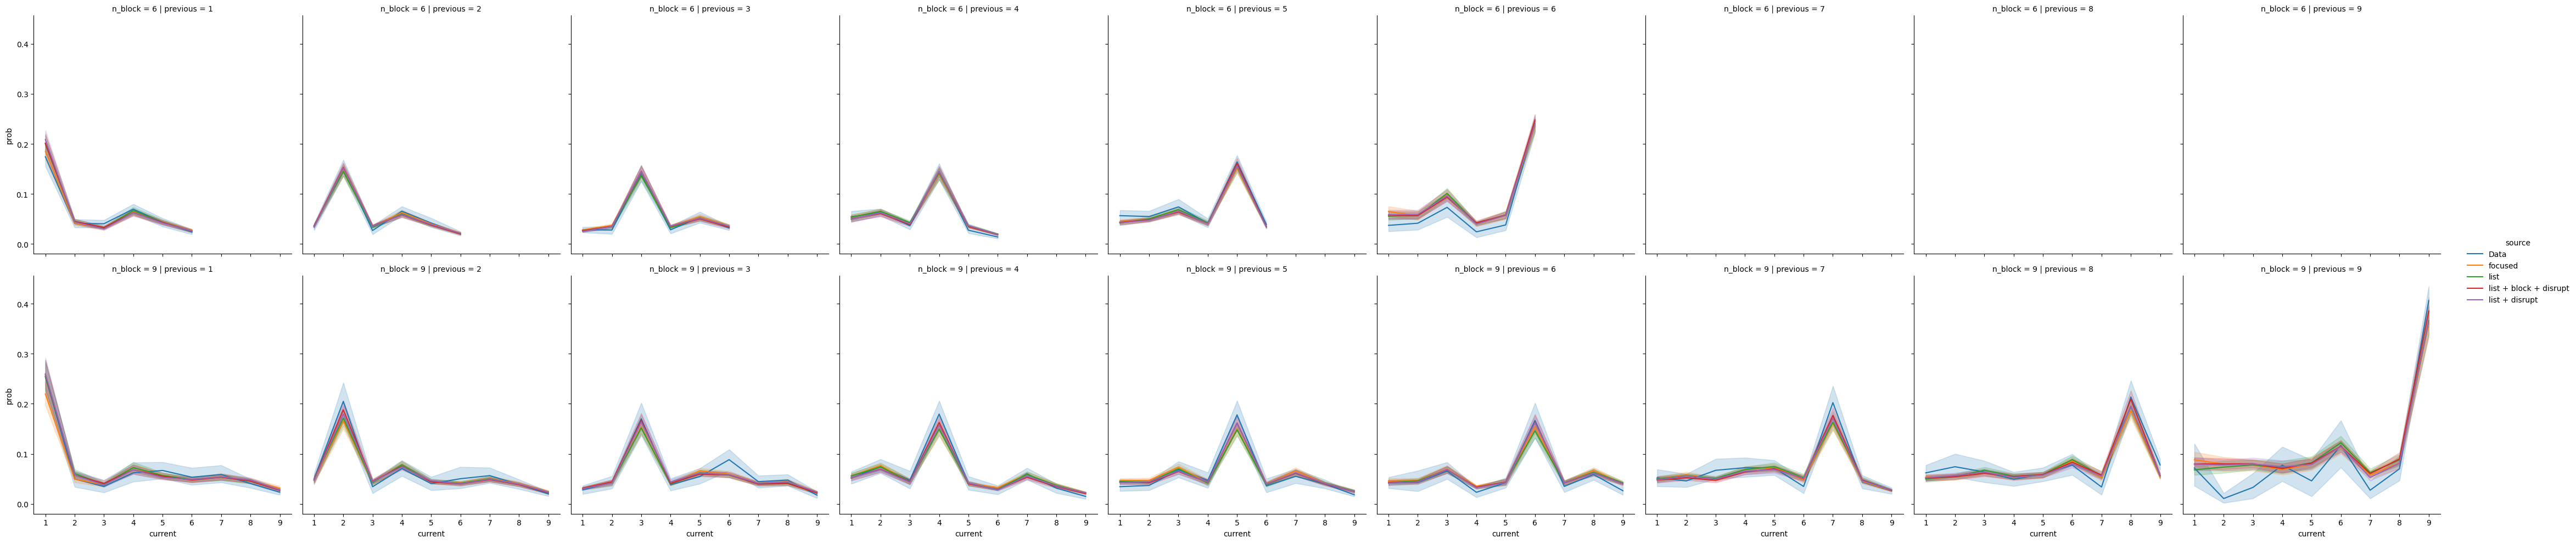

In [9]:
sns.relplot(
    input_crp, 
    x='current', 
    col='previous', 
    y='prob', 
    kind='line', 
    row='n_block', 
    hue='source',
);

In [10]:
train_crp = full.groupby(['source', 'n_block']).apply(
    fr.lag_crp, 
    lag_key='block', 
    test_key='category', 
    test=lambda x, y: x == y, 
    count_unique=True,
    include_groups=False,
)

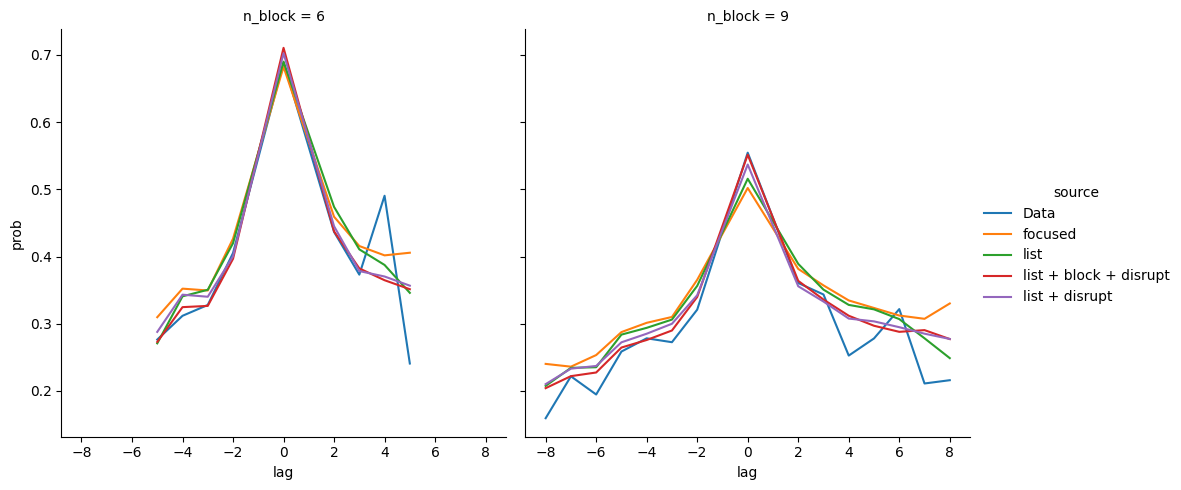

In [11]:
g = sns.relplot(
    train_crp, 
    x='lag', 
    y='prob', 
    kind='line', 
    col='n_block', 
    hue='source', 
    errorbar=None,
);
g.savefig('/Users/nmorton/Downloads/train_crp.pdf')

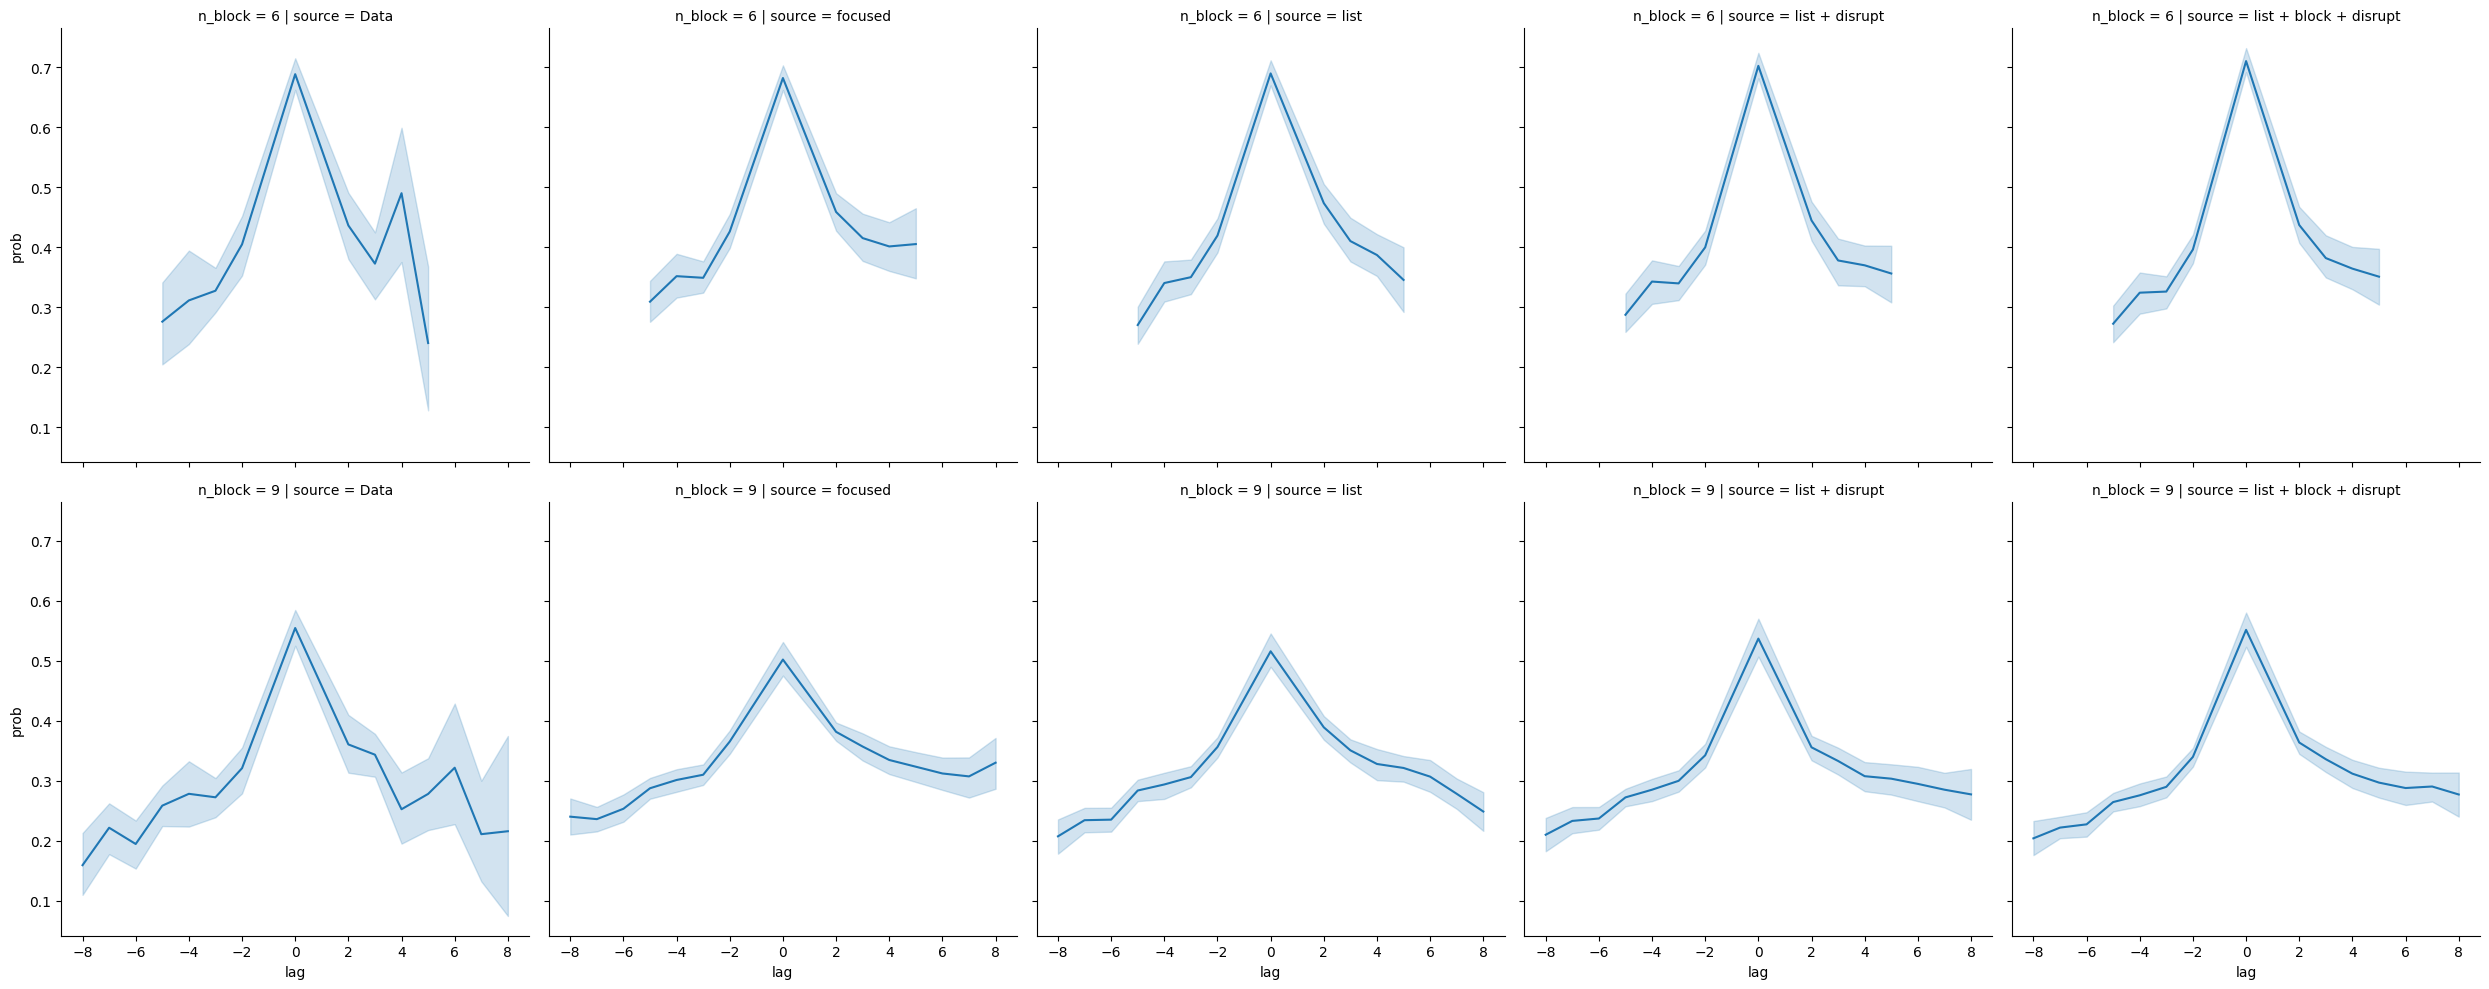

In [12]:
sns.relplot(
    train_crp, 
    x='lag', 
    y='prob', 
    kind='line', 
    row='n_block', 
    col='source', 
    col_order=['Data'] + model_names,
);

In [13]:
train_crp = full.groupby(['source', 'n_block']).apply(
    fr.lag_crp, 
    lag_key='block', 
    test_key='category', 
    test=lambda x, y: x != y, 
    count_unique=True,
    include_groups=False,
)

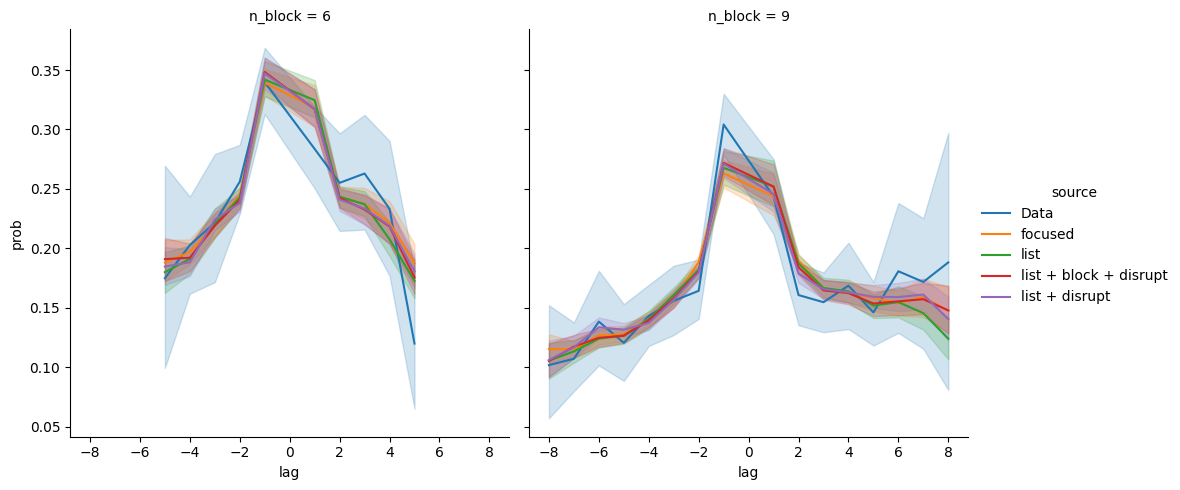

In [14]:
sns.relplot(train_crp, x='lag', y='prob', kind='line', col='n_block', hue='source');

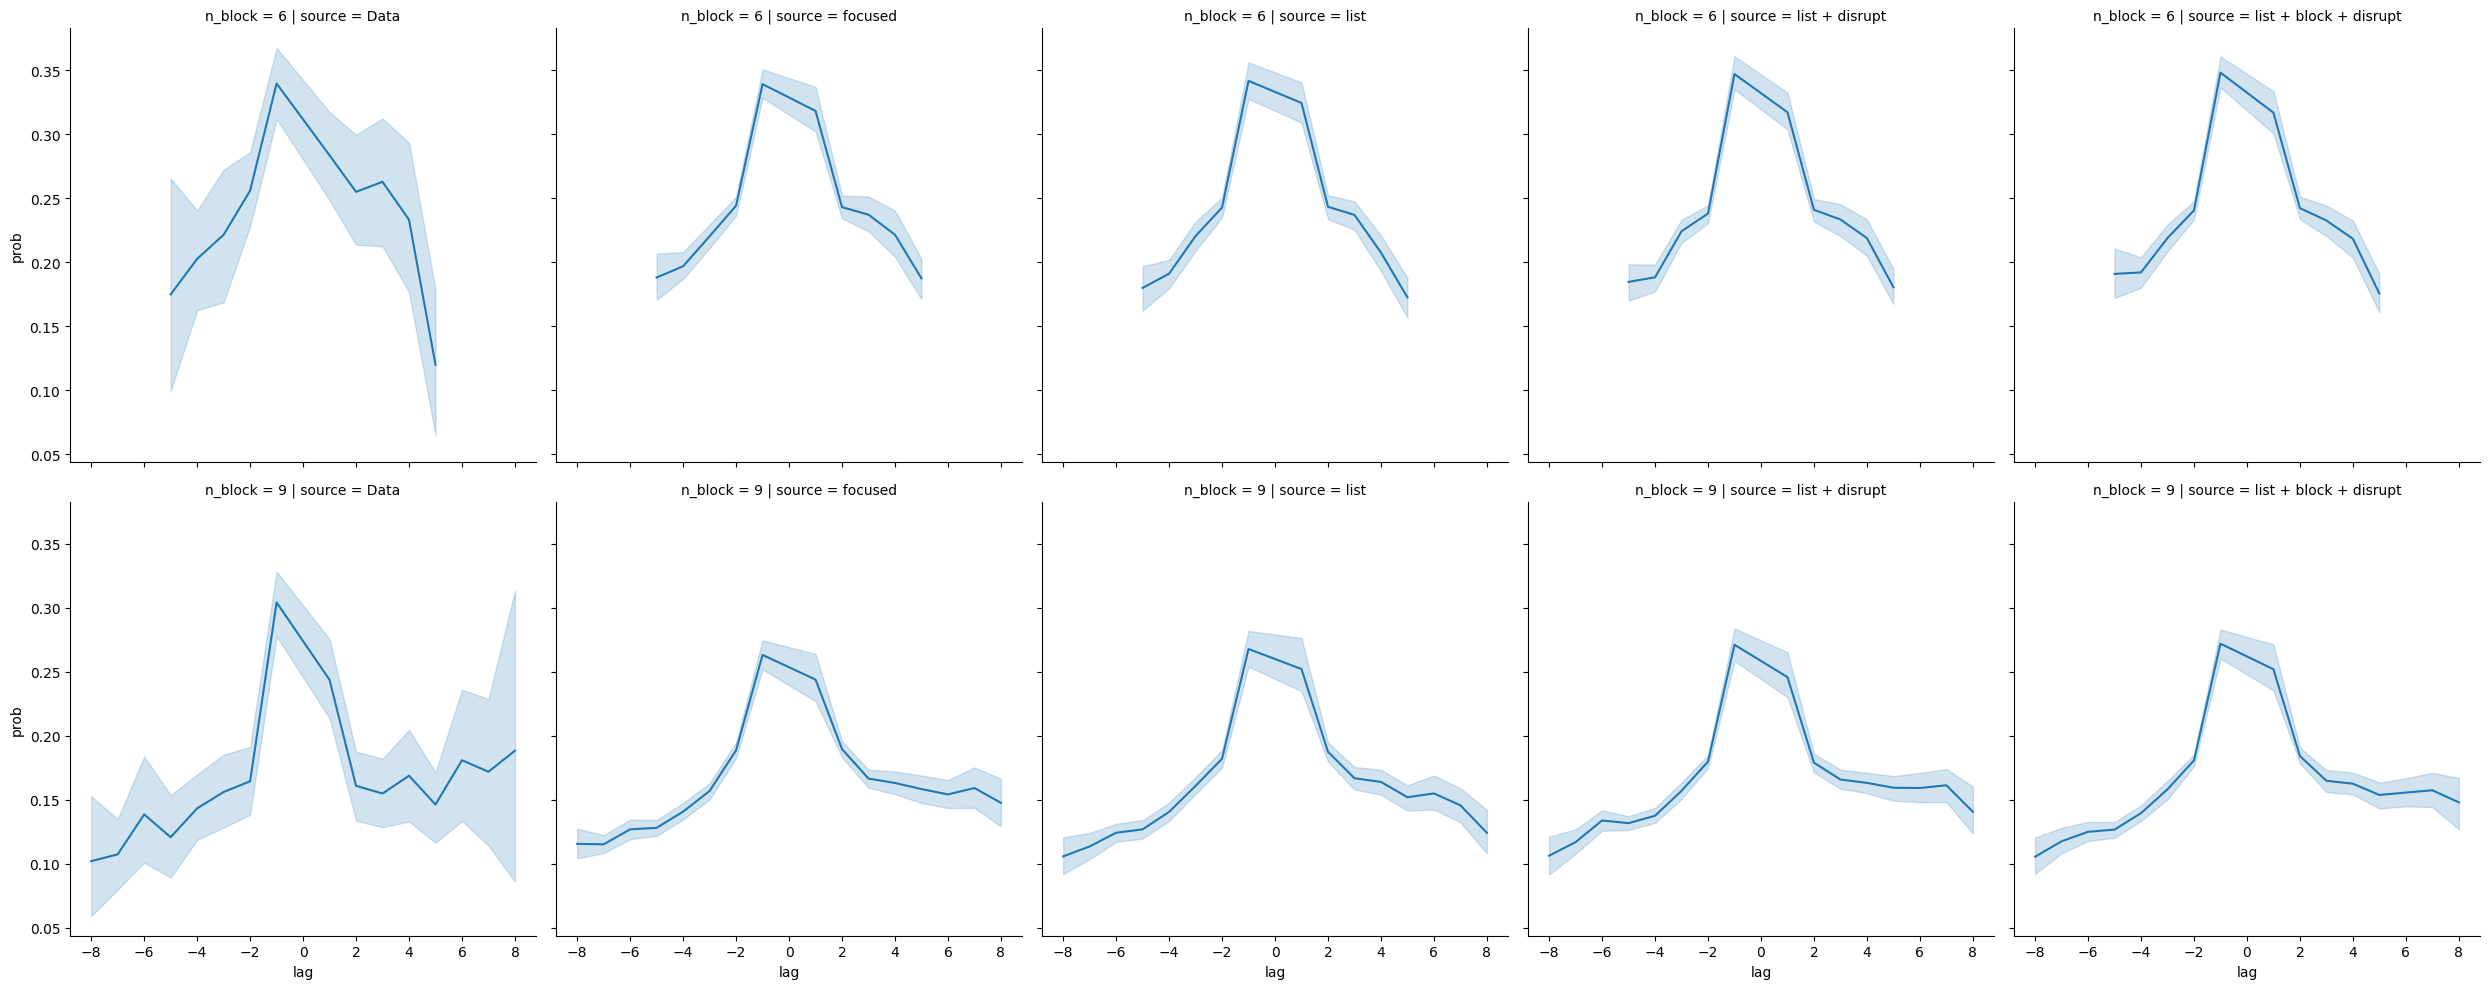

In [15]:
sns.relplot(
    train_crp, 
    x='lag', 
    y='prob', 
    kind='line', 
    row='n_block', 
    col='source', 
    col_order=['Data'] + model_names,
);

In [16]:
lag_crp = full.groupby(['source', 'n_block']).apply(
    fr.lag_crp, test_key='category', test=lambda x, y: x == y, include_groups=False
)

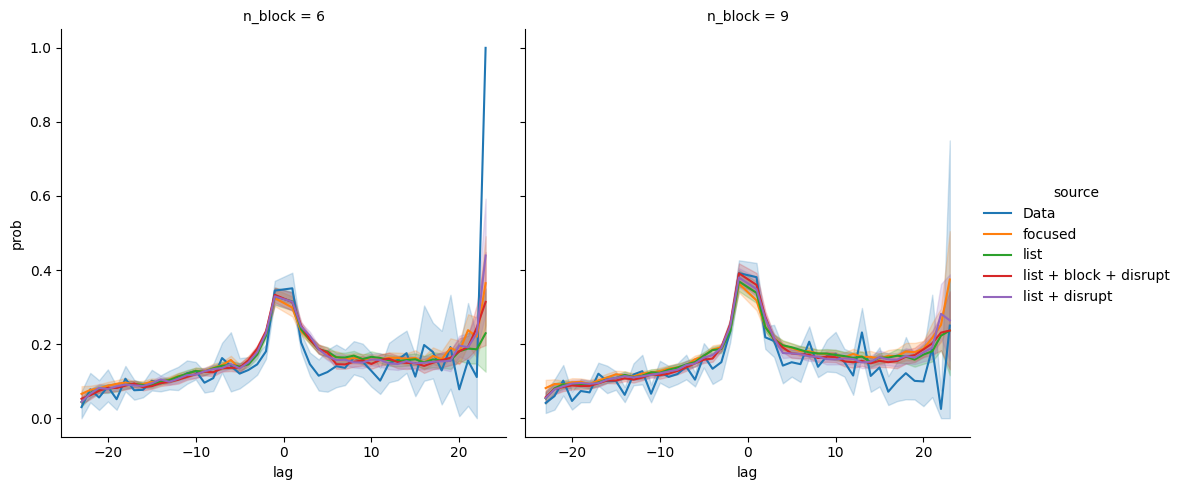

In [17]:
sns.relplot(lag_crp, x='lag', y='prob', kind='line', col='n_block', hue='source');

In [18]:
lag_crp = full.groupby(['source', 'n_block']).apply(
    fr.lag_crp, test_key='category', test=lambda x, y: x != y, include_groups=False
)

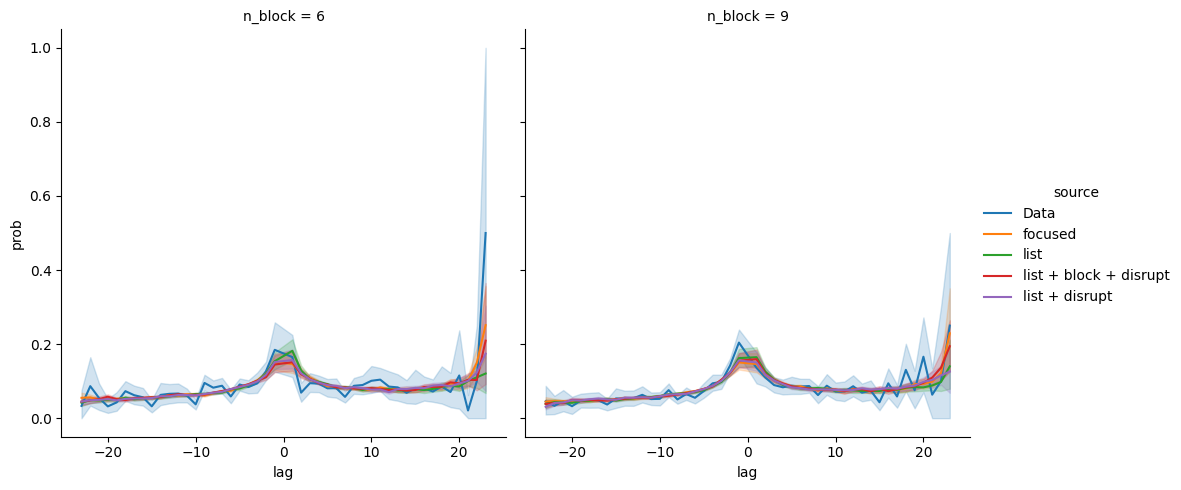

In [19]:
sns.relplot(lag_crp, x='lag', y='prob', kind='line', col='n_block', hue='source');

In [82]:
middle_block = (data['block'] != 1) & (data['block'] < data['n_block'])
block_len = data['block_len'].dropna().unique()
data['block_info'] = data['block_len'].astype("Int64").astype(str).str.cat(data['block_pos'].astype("Int64").astype(str))
data.loc[~middle_block, 'block_info'] = ''

In [83]:
bl = []
bp = []
res_list = []
for i in block_len:
    for j in range(1, i + 1):
        info = f'{i}{j}'
        crp = fr.category_crp(data, 'category', test_key='block_info', test=lambda x, y: x == info)
        crp['block_len'] = i
        crp['block_pos'] = j
        crp['block_end'] = j - i - 1
        res_list.append(crp)

In [84]:
crp = pd.concat(res_list, axis=0, ignore_index=True)
crp

,subject,prob,actual,possible,block_len,block_pos,block_end
0,1,0.480000,12,25,2,1,-2
1,2,0.620690,18,29,2,1,-2
2,3,0.545455,12,22,2,1,-2
3,5,0.781250,25,32,2,1,-2
4,8,0.444444,8,18,2,1,-2
...,...,...,...,...,...,...,...
575,42,1.000000,2,2,5,5,-1
576,43,0.500000,3,6,5,5,-1
577,44,0.666667,2,3,5,5,-1
578,45,0.400000,2,5,5,5,-1


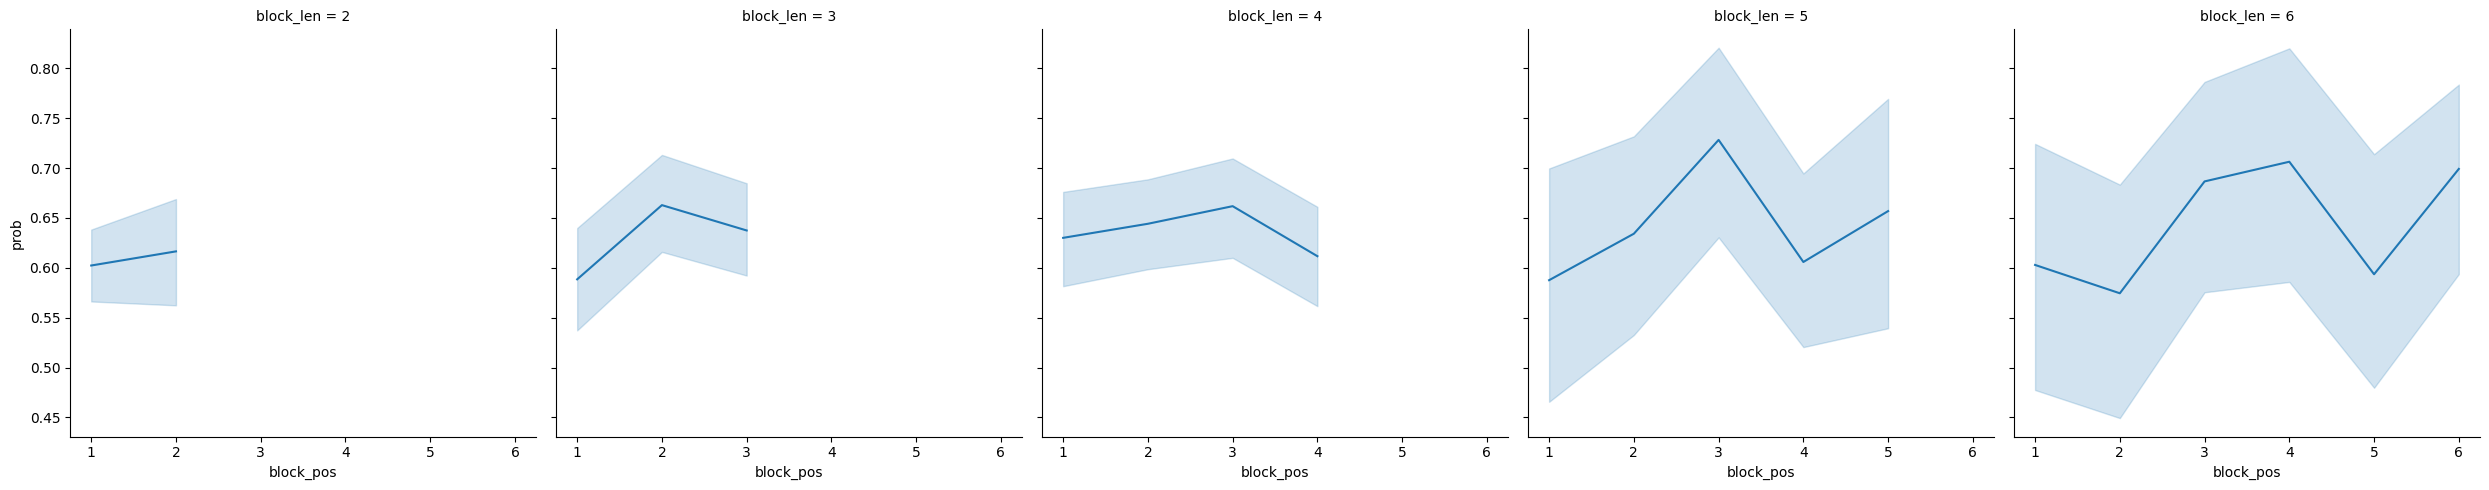

In [86]:
sns.relplot(
    crp, x='block_pos', y='prob', col='block_len', kind='line', row_order=subj_sort
);

In [63]:
def regress(data):
    x = data['block_pos'].to_numpy()[:, np.newaxis]
    y = data['prob'].to_numpy()
    if np.any(np.isnan(y)):
        b = np.nan
        return b
        
    model = lm.LinearRegression()
    model.fit(x, y)
    b = model.coef_[0]
    return b

In [70]:
data.groupby('block_pos')['block_pos'].count()

block_pos
1    6557
2    6582
3    4208
4    2428
5     854
6     430
Name: block_pos, dtype: int64[pyarrow]

In [76]:
res = crp.query('block_pos <= 3').groupby(['subject', 'block_len']).apply(regress, include_groups=False)
res.name = "slope"
res = res.reset_index()

In [78]:
pg.ttest(res.groupby('subject')['slope'].mean(), 0, alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.768097,28,greater,0.04397,"[0.0, inf]",0.328327,1.561,0.532002


In [88]:
res = crp.query('block_end >= -3').groupby(['subject', 'block_len']).apply(regress, include_groups=False)
res.name = "slope"
res = res.reset_index()

In [91]:
pg.ttest(res.groupby('subject')['slope'].mean(), 0, alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.588784,28,less,0.280363,"[-inf, 0.02]",0.109334,0.463,0.142263


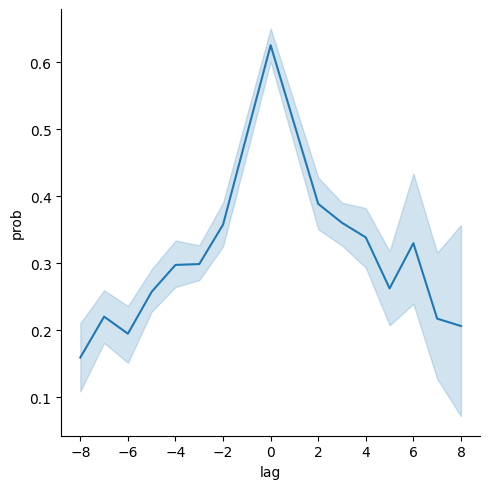

In [31]:
lag_crp = fr.lag_crp(
    data, 
    lag_key='block', 
    test_key='category', 
    test=lambda x, y: x == y, 
    count_unique=True,
)
sns.relplot(lag_crp, x='lag', y='prob', kind='line');
plt.show()

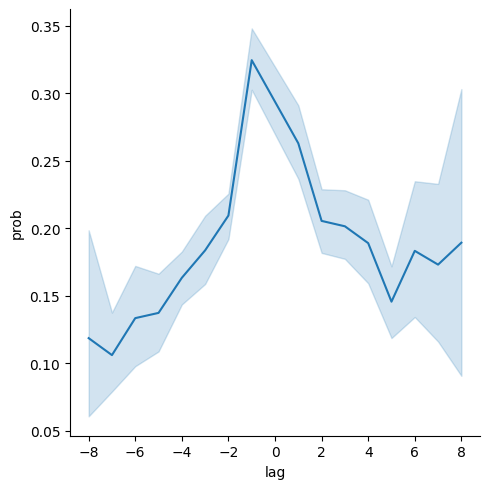

In [32]:
lag_crp = fr.lag_crp(
    data, 
    lag_key='block', 
    test_key='category', 
    test=lambda x, y: x != y, 
    count_unique=True,
)
sns.relplot(lag_crp, x='lag', y='prob', kind='line');
plt.show()

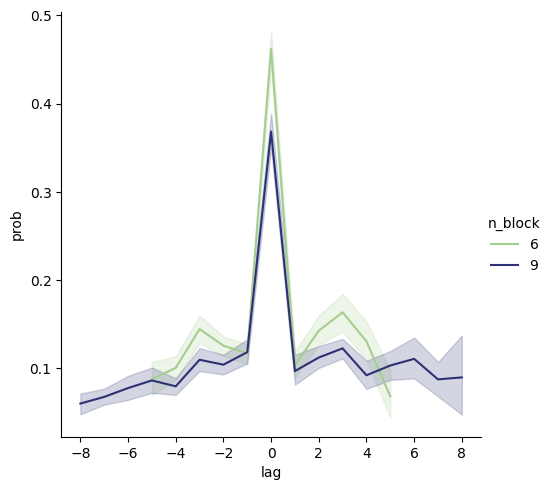

In [33]:
lag_crp = data.groupby('n_block').apply(
    fr.lag_crp, lag_key='block', count_unique=True, include_groups=False
)
sns.relplot(lag_crp, x='lag', y='prob', kind='line', hue='n_block', palette='crest');
plt.show()

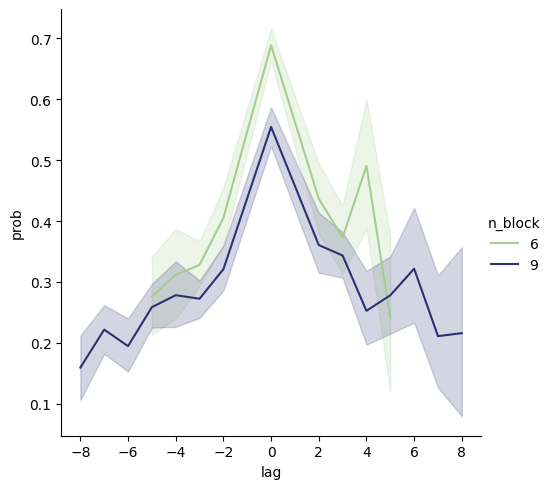

In [34]:
lag_crp = data.groupby('n_block').apply(
    fr.lag_crp, 
    lag_key='block', 
    test_key='category', 
    test=lambda x, y: x == y, 
    count_unique=True,
    include_groups=False,
)
sns.relplot(lag_crp, x='lag', y='prob', kind='line', hue='n_block', palette='crest');
plt.show()

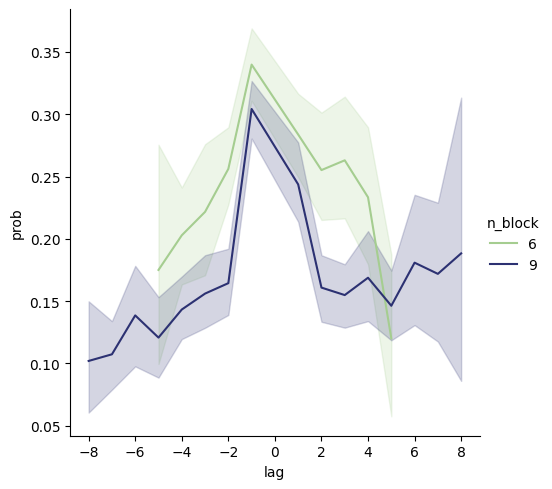

In [35]:
lag_crp = data.groupby('n_block').apply(
    fr.lag_crp, 
    lag_key='block', 
    test_key='category', 
    test=lambda x, y: x != y, 
    count_unique=True,
    include_groups=False,
)
sns.relplot(lag_crp, x='lag', y='prob', kind='line', hue='n_block', palette='crest');
plt.show()

In [36]:
dist = 1 - patterns['similarity']['use']
res_list = []
for i in range(1, 25):
    rank = fr.distance_rank(
        data, 'item_index', dist, test_key='input', test=lambda x, y: (x == i) & (y > 0)
    )
    rank['input'] = i
    res_list.append(rank)

In [37]:
rank = pd.concat(res_list, axis=0, ignore_index=True)

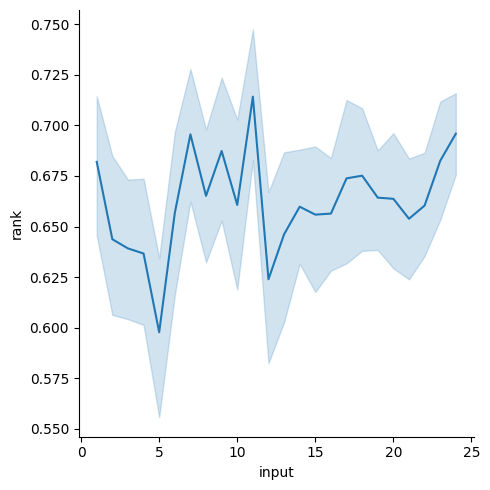

In [38]:
sns.relplot(rank, x='input', y='rank', kind='line');

In [39]:
res_list = []
for i in range(1, 25):
    crp = fr.category_crp(
        data, 'category', test_key='input', test=lambda x, y: (x == i) & (y > 0)
    )
    crp['input'] = i
    res_list.append(crp)

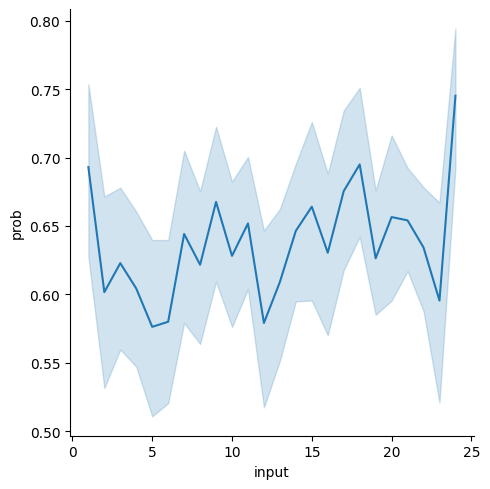

In [40]:
crp = pd.concat(res_list, axis=0, ignore_index=True)
sns.relplot(crp, x='input', y='prob', kind='line');

In [41]:
middle_block = (data['block'] != 1) & (data['block'] < data['n_block']) & (data['block_len'] > 2)
data['block_start'] = (data['block_pos'] == 1) & middle_block
data['block_end'] = (data['block_pos'] == data['block_len']) & middle_block
data.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,session,...,n_block,block_pos,block_len,curr,prev,next,base,block_info,block_start,block_end
0,1,2,SEAN PENN,1,5,True,True,0,False,1,...,6,1,2,cel,<NA>,loc,<NA>,,False,False
1,1,2,AUDREY HEPBURN,2,<NA>,True,False,0,False,1,...,6,2,2,cel,<NA>,loc,<NA>,,False,False
2,1,2,ST PATRICKS CATHEDRAL,3,11,True,True,0,False,1,...,6,1,4,loc,cel,obj,obj,41,True,False
3,1,2,LES INVALIDES,4,<NA>,True,False,0,False,1,...,6,2,4,loc,cel,obj,obj,42,False,False
4,1,2,GREAT ZIMBABWE RUINS,5,<NA>,True,False,0,False,1,...,6,3,4,loc,cel,obj,obj,43,False,False


In [42]:
crp_start = fr.category_crp(data, 'category', test_key='block_start', test=lambda x, y: x)
crp_start.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.610975,24.551724,39.586207
sem,2.595468,0.018210,1.814410,2.206974


In [43]:
crp_end = fr.category_crp(data, 'category', test_key='block_end', test=lambda x, y: x)
crp_end.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.640382,27.000000,41.931034
sem,2.595468,0.019372,1.651242,1.871441


In [44]:
pg.ttest(crp_start['prob'], crp_end['prob'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.409039,28,two-sided,0.169833,"[-0.07, 0.01]",0.290465,0.48,0.326873


In [45]:
crp_early = fr.category_crp(data, 'category', test_key='input', test=lambda x, y: x <= 8)
crp_early.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.618081,58.827586,93.724138
sem,2.595468,0.014150,3.760394,4.808115


In [46]:
crp_mid = fr.category_crp(data, 'category', test_key='input', test=lambda x, y: (x > 8) & (x <= 16))
crp_mid.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.637276,55.931034,87.137931
sem,2.595468,0.013557,3.487109,4.438891


In [47]:
crp_late = fr.category_crp(data, 'category', test_key='input', test=lambda x, y: x > 16)
crp_late.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.661312,91.827586,137.689655
sem,2.595468,0.015303,4.118344,4.122838


In [48]:
pg.ttest(crp_late['prob'], crp_early['prob'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.039101,28,two-sided,0.000378,"[0.02, 0.07]",0.544702,79.177,0.808243


In [49]:
crp_prim = fr.category_crp(data, 'category', test_key='input', test=lambda x, y: x <= 3)
crp_prim.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.644416,25.413793,38.896552
sem,2.595468,0.019010,1.890159,2.397322


In [50]:
crp_post = fr.category_crp(data, 'category', test_key='input', test=lambda x, y: (x > 3) & (x <= 6))
crp_post.agg(['mean', 'sem'])

,subject,prob,actual,possible
mean,27.000000,0.588027,20.275862,34.137931
sem,2.595468,0.018158,1.350877,1.719723


In [51]:
pg.ttest(crp_prim['prob'], crp_post['prob'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.63105,28,two-sided,0.013684,"[0.01, 0.1]",0.563307,3.498,0.833486
